# Introduction

This is the notebook to analyse data for "Single cell mRNA signals reveal the developmental state of KMT2A-rearranged infant pre-B cell leukaemia" paper (doi: ...).

1. <a href='#preprocess'>Preprocessing and filtering'</a>
2. <a href='#cluster'>Clustering and UMAP'</a>
3. <a href='#logreg'>Logistic regression'</a>

<a id='preprocess'></a>
Single cell data was collected and processed at 3 different timepoints.

1. Experiment 1: 
    - InfALL1M_InfALL2F_Dx_run1/_run2: two channels of InfALL1 multiplexed with InfALL2
    - InfAML1_Dx: one channel of InfAML1
2. Experiment 2: 
    - InfALL3_InfML2_Dx_run1/_run2: one channels of InfALL3 multiplexed with InfAML2
    - InfALL4_Dx_run1/_run2: two channels of InfALL4
3. Experiment 3: one channel of InfALL5 multiplexed with InfALL_classSwitch, one channel of InfALL6, one channel of InfALL7_ETV6 and one for InfALL8_NUMT1

Raw fastq files were processed with with cellranger v3.0.2, which aligned the reads to reference genome (GRCh38 v1.2.0)  and produced matrix of gene expression per single cell.  
Ambient mRNA contamination was removed with SoupX package in R. Demultiplexing of InfALL1/InfALL2, InfALL3/InfAML2 and InfALL5/InfALL6 was performed with souporcell (https://doi.org/10.1038/s41592-020-0820-1) using following command:  
`singularity exec souporcell_latest.sif souporcell_pipeline.py -i possorted_genome_bam.bam -b barcodes.tsv -f genome.fa -t 20 -o souporcell_2 -k 2 --min_ref 4  --min_alt 4`

Souporcell produced clusters.tsv file that we can use to demultiplex data. Luckily for us, data was multiplexed for different genders so we can easily find out which demultiplexed sample belong to which patient using sex-specific genes such as XIST or y-specific genes such as  RPS4Y1, ZFY and couple of others.

**All the data is located in 'data' folder, with cellranger output located in 'raw_counts' and SoupX processed data located in 'SoupX_processed_counts' (you will need to unzip it first)**


Ok, let's load the data (after SoupX), demultiplex it and run some basic QC.  
We will start with two channels of InfALL1 multiplexed with InfALL2:

First run: multiplexed InfALL1M with InfALL2F after SoupX have  1154  cells


         Falling back to preprocessing with `sc.pp.pca` and default params.
... storing 'souporcell' as categorical


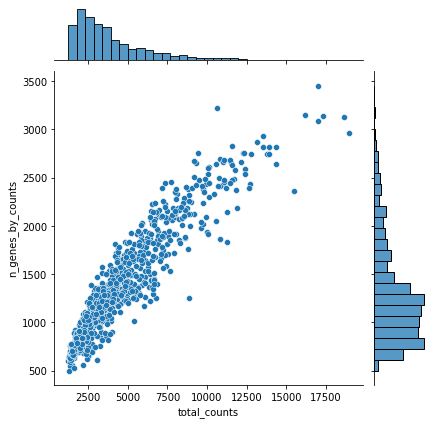

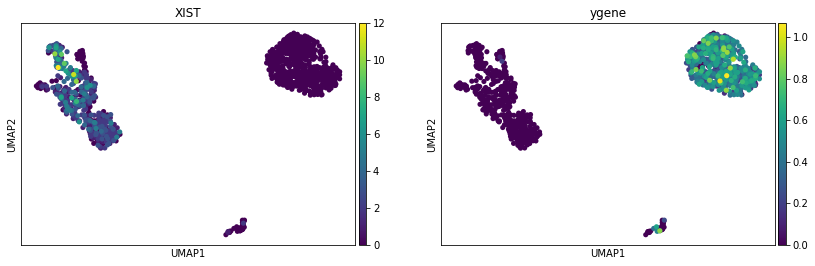

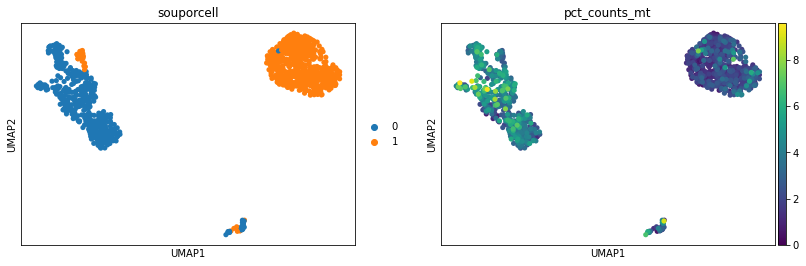

demultiplexed InfALL1M in first run have  634  cells
demultiplexed InfALL2F in first run have  498  cells


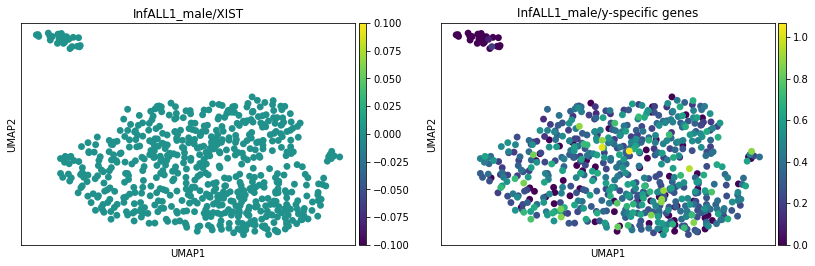

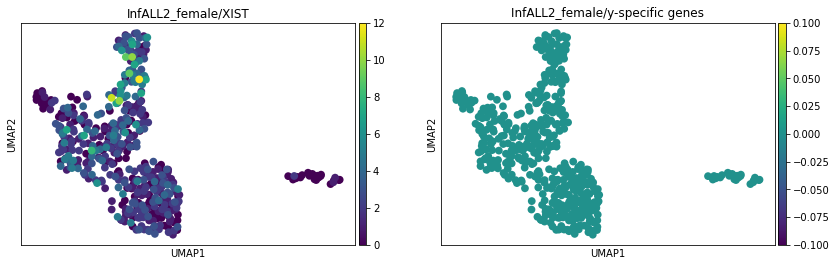

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import scipy
import seaborn as sns


mito_cutoff = 10

# Read SoupX processed data
adata1 = sc.read_10x_mtx('data/single_cell_data/SoupX_processed_counts/ALL_AML_1/InfALL1M_InfALL2F_Dx_run1_strained/', var_names='gene_symbols', cache=True)
adata1.raw = adata1
print('First run: multiplexed InfALL1M with InfALL2F after SoupX have ', adata1.shape[0], ' cells')
sc.pp.filter_cells(adata1, min_genes=200)
adata1.var['mt'] = adata1.var_names.str.startswith('MT-') 
sc.pp.calculate_qc_metrics(adata1, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
# filter cells with mito content >20%
adata1 = adata1[adata1.obs.pct_counts_mt<mito_cutoff].copy()
sns.jointplot(data=adata1.obs, x="total_counts", y="n_genes_by_counts")
sc.pp.normalize_per_cell(adata1, counts_per_cell_after=1e4)
sc.pp.log1p(adata1)
sc.pp.neighbors(adata1)
sc.tl.umap(adata1)
sorcell = pd.read_csv('data/single_cell_data/InfALL1M_InfALL2F_Dx_run1_clusters.tsv', sep = '\t', index_col=0)
sorcell = sorcell[sorcell.status == 'singlet']
adata1 = adata1[adata1.obs_names.isin(sorcell.index)].copy()

adata1.obs['souporcell'] = sorcell.assignment

# we use combination if 
adata1.obs['ygene']= np.mean(adata1[:, ['RPS4Y1', 'ZFY', 'DDX3Y', 'UTY', 'TMSB4Y', 'KDM5D', 'EIF1AY']].X, 1)

sc.pl.umap(adata1, color = ['XIST', 'ygene'], ncols = 2)
sc.pl.umap(adata1, color = ['souporcell','pct_counts_mt'])

adataInfALL1Mrun1 = adata1[adata1.obs['souporcell'] == '1']
adataInfALL2Frun1 = adata1[adata1.obs['souporcell'] == '0']
print('demultiplexed InfALL1M in first run have ', adataInfALL1Mrun1.shape[0], ' cells')
print('demultiplexed InfALL2F in first run have ', adataInfALL2Frun1.shape[0], ' cells')

sc.pp.neighbors(adataInfALL1Mrun1)
sc.tl.umap(adataInfALL1Mrun1)

sc.pp.neighbors(adataInfALL2Frun1)
sc.tl.umap(adataInfALL2Frun1)

sc.pl.umap(adataInfALL1Mrun1, color = ['XIST', 'ygene'], ncols = 2, title = ['InfALL1_male/XIST','InfALL1_male/y-specific genes'])
sc.pl.umap(adataInfALL2Frun1, color = ['XIST', 'ygene'], ncols = 2, title = ['InfALL2_female/XIST','InfALL2_female/y-specific genes'])


And now the same for second channel

Second run: multiplexed InfALL1M with InfALL2F after SoupX have  1209  cells


         Falling back to preprocessing with `sc.pp.pca` and default params.
... storing 'souporcell' as categorical


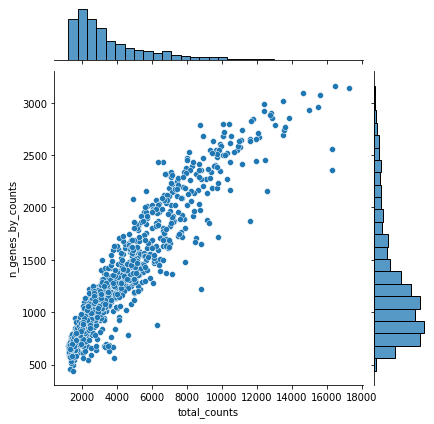

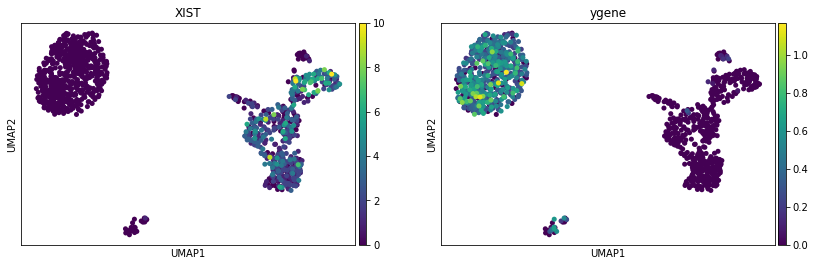

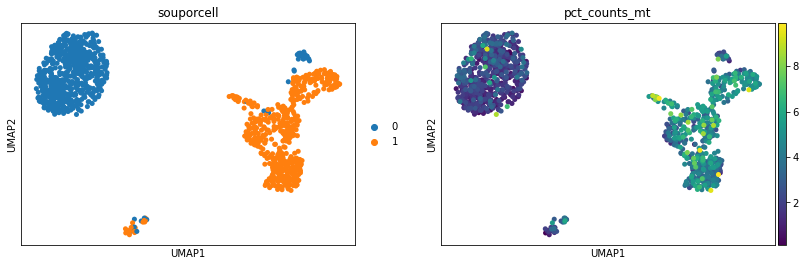

demultiplexed InfALL1M in second run have  632  cells
demultiplexed InfALL2F in second run have  536  cells


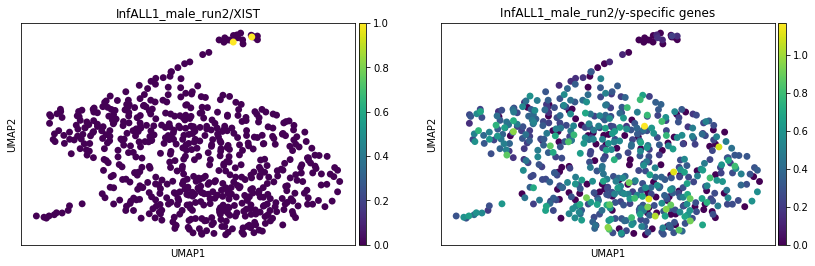

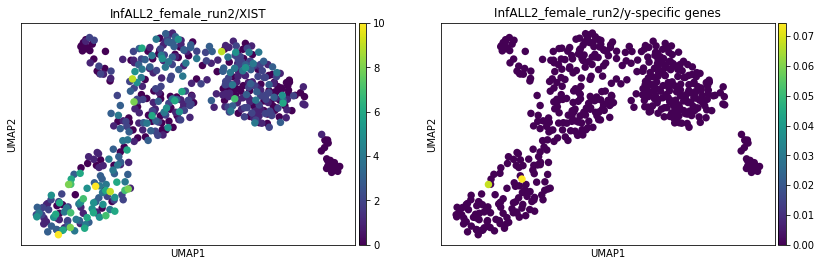

In [3]:
# Read SoupX processed data
adata2 = sc.read_10x_mtx('data/single_cell_data/SoupX_processed_counts/ALL_AML_1/InfALL1M_InfALL2F_run2_strained/', var_names='gene_symbols', cache=True)
adata2.raw = adata2
print('Second run: multiplexed InfALL1M with InfALL2F after SoupX have ', adata2.shape[0], ' cells')
sc.pp.filter_cells(adata2, min_genes=200)
adata2.var['mt'] = adata2.var_names.str.startswith('MT-') 
sc.pp.calculate_qc_metrics(adata2, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
# filter cells with mito content >20%
adata2 = adata2[adata2.obs.pct_counts_mt<mito_cutoff].copy()
sns.jointplot(data=adata2.obs, x="total_counts", y="n_genes_by_counts")
sc.pp.normalize_per_cell(adata2, counts_per_cell_after=1e4)
sc.pp.log1p(adata2)
sc.pp.neighbors(adata2)
sc.tl.umap(adata2)
sorcell = pd.read_csv('data/single_cell_data/InfALL1M_InfALL2F_Dx_run2_clusters.tsv', sep = '\t', index_col=0)
sorcell = sorcell[sorcell.status == 'singlet']
adata2 = adata2[adata2.obs_names.isin(sorcell.index)].copy()

adata2.obs['souporcell'] = sorcell.assignment

# we use combination if 
adata2.obs['ygene']= np.mean(adata2[:, ['RPS4Y1', 'ZFY', 'DDX3Y', 'UTY', 'TMSB4Y', 'KDM5D', 'EIF1AY']].X, 1)

sc.pl.umap(adata2, color = ['XIST', 'ygene'], ncols = 2)
sc.pl.umap(adata2, color = ['souporcell','pct_counts_mt'])

adataInfALL1Mrun2 = adata2[adata2.obs['souporcell'] == '0']
adataInfALL2Frun2 = adata2[adata2.obs['souporcell'] == '1']
print('demultiplexed InfALL1M in second run have ', adataInfALL1Mrun2.shape[0], ' cells')
print('demultiplexed InfALL2F in second run have ', adataInfALL2Frun2.shape[0], ' cells')

sc.pp.neighbors(adataInfALL1Mrun2)
sc.tl.umap(adataInfALL1Mrun2)

sc.pp.neighbors(adataInfALL2Frun2)
sc.tl.umap(adataInfALL2Frun2)

sc.pl.umap(adataInfALL1Mrun2, color = ['XIST', 'ygene'], ncols = 2, title = ['InfALL1_male_run2/XIST','InfALL1_male_run2/y-specific genes'])
sc.pl.umap(adataInfALL2Frun2, color = ['XIST', 'ygene'], ncols = 2, title = ['InfALL2_female_run2/XIST','InfALL2_female_run2/y-specific genes'])


We will combine single cell data from 2 channels into one object. AnnData object contains normalized and log processed data in adata.X slot but we can get raw counts back using following command:
`adata_RAW = adata.raw.to_adata()`

combined InfALL1 (male) from 2 channels:


... storing 'souporcell' as categorical


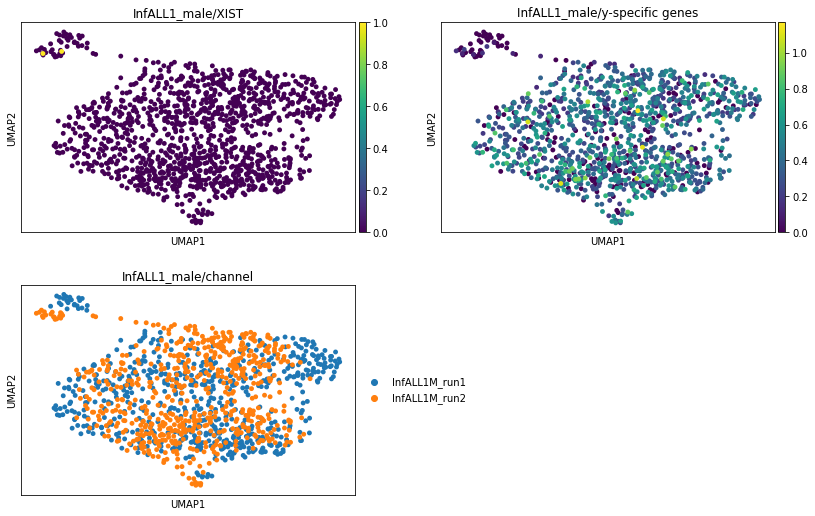

Combined InfALL1 (male) from both runs have  1266  cells
combined InfALL2 (female) from 2 channels:


... storing 'souporcell' as categorical


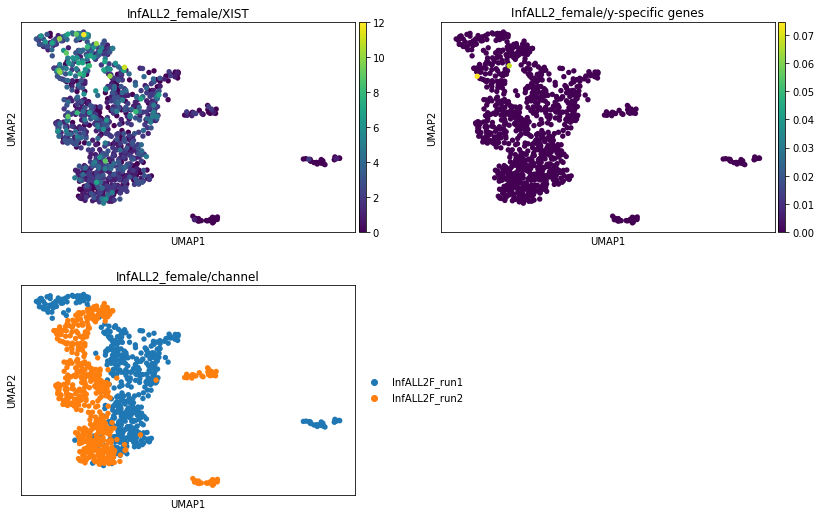

Combined InfALL2 (female) from both runs have  1034  cells


In [4]:
print('combined InfALL1 (male) from 2 channels:')
adata_InfALL1 = adataInfALL1Mrun1.concatenate(adataInfALL1Mrun2, batch_categories=['InfALL1M_run1', 'InfALL1M_run2'])
sc.pp.neighbors(adata_InfALL1)
sc.tl.umap(adata_InfALL1)
sc.pl.umap(adata_InfALL1, color = ['XIST', 'ygene', 'batch'], ncols = 2, title = ['InfALL1_male/XIST','InfALL1_male/y-specific genes', 'InfALL1_male/channel'])
print('Combined InfALL1 (male) from both runs have ', adata_InfALL1.shape[0], ' cells')

print('combined InfALL2 (female) from 2 channels:')
adata_InfALL2 = adataInfALL2Frun1.concatenate(adataInfALL2Frun2, batch_categories=['InfALL2F_run1', 'InfALL2F_run2'])
sc.pp.neighbors(adata_InfALL2)
sc.tl.umap(adata_InfALL2)
sc.pl.umap(adata_InfALL2, color = ['XIST', 'ygene', 'batch'], ncols = 2, title = ['InfALL2_female/XIST','InfALL2_female/y-specific genes', 'InfALL2_female/channel'])
print('Combined InfALL2 (female) from both runs have ', adata_InfALL2.shape[0], ' cells')

Let's process last sample from the first experiment: InfAML1

InfAML1 after SoupX have  1209  cells


         Falling back to preprocessing with `sc.pp.pca` and default params.


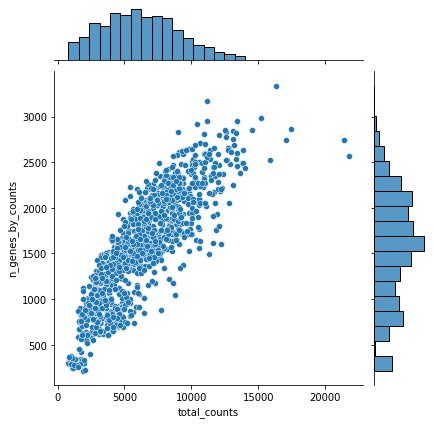

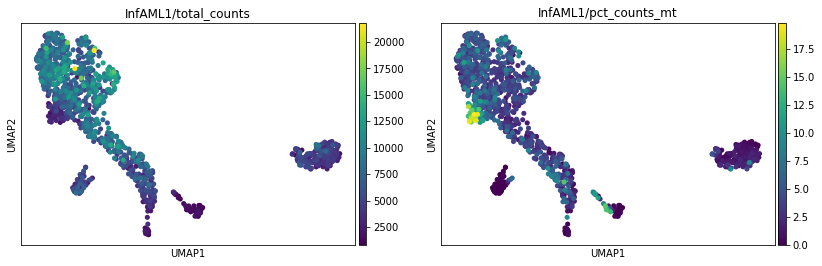

After filtering and preprocessing InfAML1 have  1149  cells


In [5]:
# Read SoupX processed data
adata_infAML1 = sc.read_10x_mtx('data/single_cell_data/SoupX_processed_counts/ALL_AML_1/InfAML1_Dx_strained/', var_names='gene_symbols', cache=True)
adata_infAML1.raw = adata_infAML1
print('InfAML1 after SoupX have ', adata_infAML1.shape[0], ' cells')
sc.pp.filter_cells(adata_infAML1, min_genes=200)
adata_infAML1.var['mt'] = adata_infAML1.var_names.str.startswith('MT-') 
sc.pp.calculate_qc_metrics(adata_infAML1, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
# filter cells with mito content >20%
adata_infAML1 = adata_infAML1[adata_infAML1.obs.pct_counts_mt<20].copy()
sns.jointplot(data=adata_infAML1.obs, x="total_counts", y="n_genes_by_counts")
sc.pp.normalize_per_cell(adata_infAML1, counts_per_cell_after=1e4)
sc.pp.log1p(adata_infAML1)
sc.pp.neighbors(adata_infAML1)
sc.tl.umap(adata_infAML1)
sc.pl.umap(adata_infAML1, color = ['total_counts','pct_counts_mt'], title = ['InfAML1/total_counts','InfAML1/pct_counts_mt'])

print('After filtering and preprocessing InfAML1 have ', adata_infAML1.shape[0], ' cells')

# Experiment #2

In this experiment we have one channel (runs) of InfALL3 multiplexed with InfAML2 and two channels of InfALL4. We will process them in the same way as other data.

Let's start with first run of mutiplexed data:

Multiplexed InfALL3 with InfAML2 after SoupX have  1119  cells


         Falling back to preprocessing with `sc.pp.pca` and default params.
... storing 'souporcell' as categorical


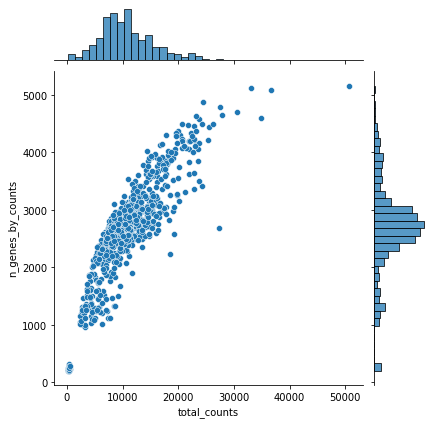

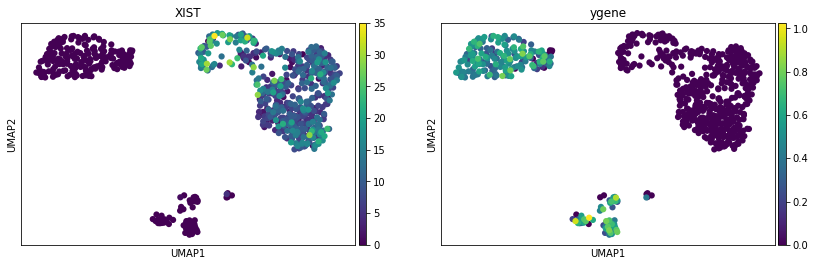

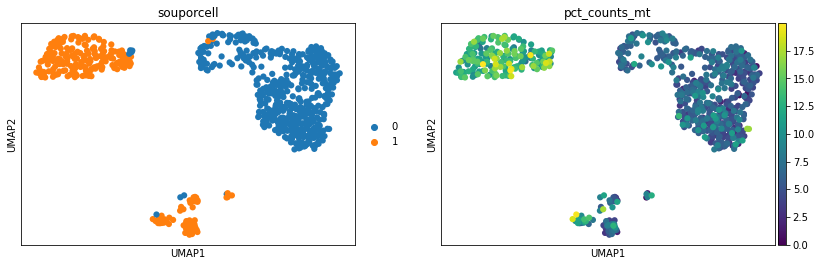

demultiplexed InfAML2 (male) have  250  cells
demultiplexed InfALL3 (female) have  521  cells


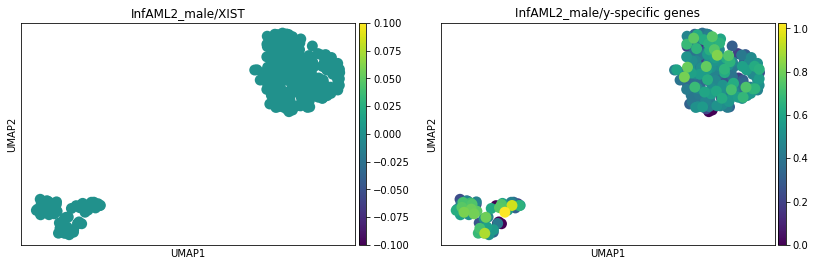

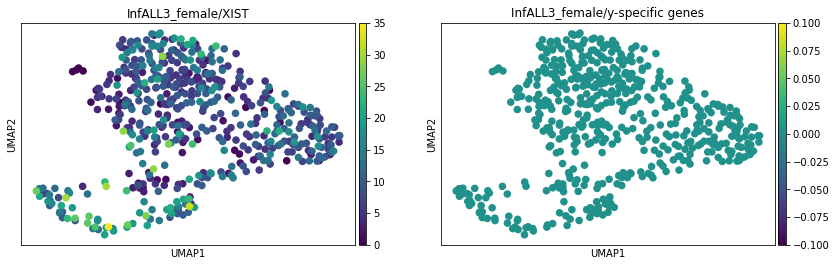

After filtering and preprocessing InfAML2 have  250  cells
After filtering and preprocessing InfALL3 have  521  cells


In [6]:
# Read SoupX processed data
adata1 = sc.read_10x_mtx('data/single_cell_data/SoupX_processed_counts/ALL_AML_2/InfALL3_InfAML2_Dx_run1_strained/', var_names='gene_symbols', cache=True)
adata1.raw = adata1
print('Multiplexed InfALL3 with InfAML2 after SoupX have ', adata1.shape[0], ' cells')
sc.pp.filter_cells(adata1, min_genes=200)
adata1.var['mt'] = adata1.var_names.str.startswith('MT-') 
sc.pp.calculate_qc_metrics(adata1, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
# filter cells with mito content >20%
adata1 = adata1[adata1.obs.pct_counts_mt<20].copy()
sns.jointplot(data=adata1.obs, x="total_counts", y="n_genes_by_counts")
sc.pp.normalize_per_cell(adata1, counts_per_cell_after=1e4)
sc.pp.log1p(adata1)
sc.pp.neighbors(adata1)
sc.tl.umap(adata1)
sorcell = pd.read_csv('data/single_cell_data/InfALL3_InfAML2_Dx_run1_clusters.tsv', sep = '\t', index_col=0)
sorcell = sorcell[sorcell.status == 'singlet']
adata1 = adata1[adata1.obs_names.isin(sorcell.index)].copy()

adata1.obs['souporcell'] = sorcell.assignment

# we use combination if 
adata1.obs['ygene']= np.mean(adata1[:, ['RPS4Y1', 'ZFY', 'DDX3Y', 'UTY', 'TMSB4Y', 'KDM5D', 'EIF1AY']].X, 1)

sc.pl.umap(adata1, color = ['XIST', 'ygene'], ncols = 2)
sc.pl.umap(adata1, color = ['souporcell','pct_counts_mt'])

adataInfAML2_male = adata1[adata1.obs['souporcell'] == '1']
adataInfALL3_female = adata1[adata1.obs['souporcell'] == '0']
print('demultiplexed InfAML2 (male) have ', adataInfAML2_male.shape[0], ' cells')
print('demultiplexed InfALL3 (female) have ', adataInfALL3_female.shape[0], ' cells')

sc.pp.neighbors(adataInfAML2_male)
sc.tl.umap(adataInfAML2_male)

sc.pp.neighbors(adataInfALL3_female)
sc.tl.umap(adataInfALL3_female)

sc.pl.umap(adataInfAML2_male, color = ['XIST', 'ygene'], ncols = 2, title = ['InfAML2_male/XIST','InfAML2_male/y-specific genes'])
sc.pl.umap(adataInfALL3_female, color = ['XIST', 'ygene'], ncols = 2, title = ['InfALL3_female/XIST','InfALL3_female/y-specific genes'])

print('After filtering and preprocessing InfAML2 have ', adataInfAML2_male.shape[0], ' cells')

print('After filtering and preprocessing InfALL3 have ', adataInfALL3_female.shape[0], ' cells')


And now load the data for InfALL4:

First run: InfALL4 after SoupX have  466  cells


         Falling back to preprocessing with `sc.pp.pca` and default params.


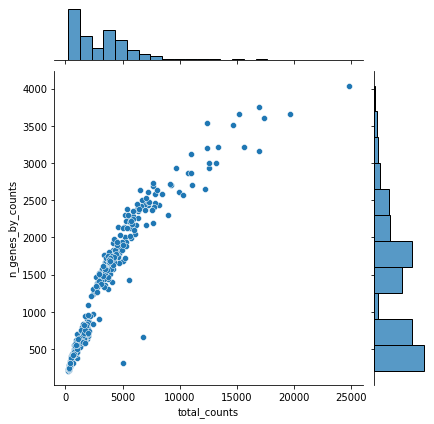

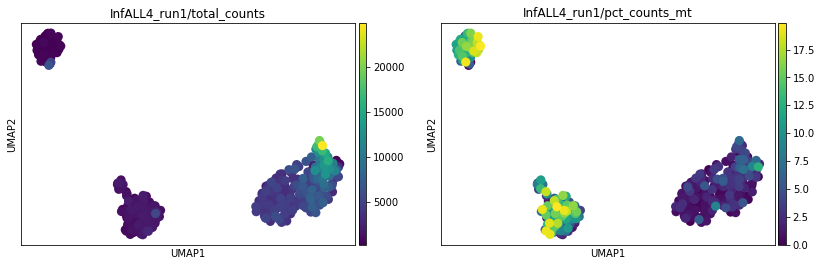

Second run: InfALL4 after SoupX have  370  cells


         Falling back to preprocessing with `sc.pp.pca` and default params.


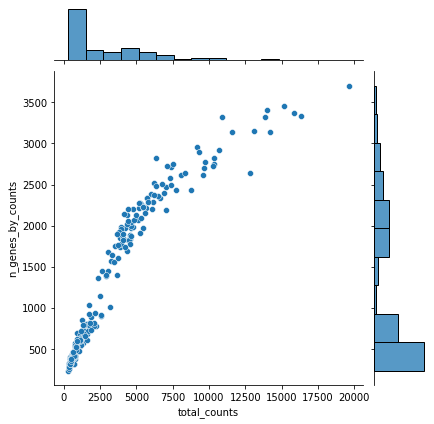

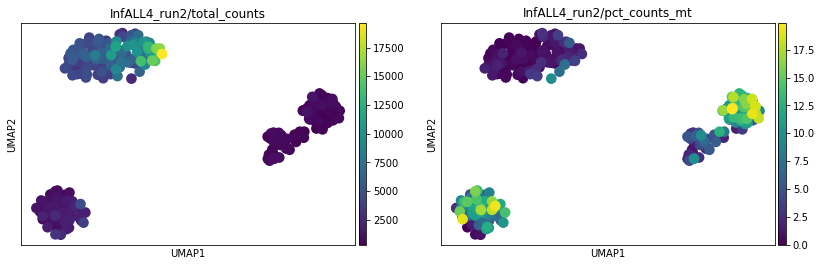

InfALL4: two channels combined have  616  cells


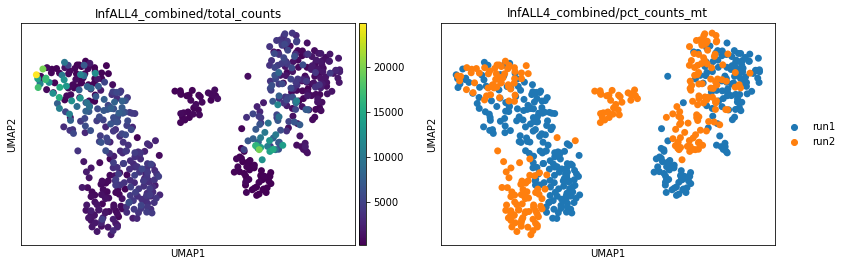

In [7]:
# Read SoupX processed data

adata1 = sc.read_10x_mtx('data/single_cell_data/SoupX_processed_counts/ALL_AML_2/InfALL4_Dx_run1_strained/', var_names='gene_symbols', cache=True)
adata1.raw = adata1
print('First run: InfALL4 after SoupX have ', adata1.shape[0], ' cells')
sc.pp.filter_cells(adata1, min_genes=200)
adata1.var['mt'] = adata1.var_names.str.startswith('MT-') 
sc.pp.calculate_qc_metrics(adata1, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
# filter cells with mito content >20%
adata1 = adata1[adata1.obs.pct_counts_mt<20].copy()
sns.jointplot(data=adata1.obs, x="total_counts", y="n_genes_by_counts")
sc.pp.normalize_per_cell(adata1, counts_per_cell_after=1e4)
sc.pp.log1p(adata1)
sc.pp.neighbors(adata1)
sc.tl.umap(adata1)

sc.pl.umap(adata1, color = ['total_counts','pct_counts_mt'], title = ['InfALL4_run1/total_counts','InfALL4_run1/pct_counts_mt'])



adata2 = sc.read_10x_mtx('data/single_cell_data/SoupX_processed_counts/ALL_AML_2/InfALL4_Dx_run2_strained/', var_names='gene_symbols', cache=True)
adata2.raw = adata2
print('Second run: InfALL4 after SoupX have ', adata2.shape[0], ' cells')
sc.pp.filter_cells(adata2, min_genes=200)
adata2.var['mt'] = adata2.var_names.str.startswith('MT-') 
sc.pp.calculate_qc_metrics(adata2, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
# filter cells with mito content >20%
adata2 = adata2[adata2.obs.pct_counts_mt<20].copy()
sns.jointplot(data=adata2.obs, x="total_counts", y="n_genes_by_counts")
sc.pp.normalize_per_cell(adata2, counts_per_cell_after=1e4)
sc.pp.log1p(adata2)
sc.pp.neighbors(adata2)
sc.tl.umap(adata2)
sc.pl.umap(adata2, color = ['total_counts','pct_counts_mt'], title = ['InfALL4_run2/total_counts','InfALL4_run2/pct_counts_mt'])

adata_InfALL4 = adata1.concatenate(adata2, batch_categories = ['run1', 'run2'])
print('InfALL4: two channels combined have ', adata_InfALL4.shape[0], ' cells')
sc.pp.neighbors(adata_InfALL4)
sc.tl.umap(adata_InfALL4)
sc.pl.umap(adata_InfALL4, color = ['total_counts','batch'], title = ['InfALL4_combined/total_counts','InfALL4_combined/pct_counts_mt'])


# Experiment 3
This experiment consisted of one channel for InfALL5 multiplexed with InfALL_classSwitch, one channel of each of: InfALL6, InfALL7_ETV6 and InfALL8_NUMT1

InfALL_classSwitch was not included in the analysis later on so we will ignore it. InfALL5 is female so we will extract the cells with cluster id corresponding to the expression of XIST.

Multiplexed InfALL5 with InfALL_classSwitch after SoupX have  3232  cells


         Falling back to preprocessing with `sc.pp.pca` and default params.
... storing 'souporcell' as categorical


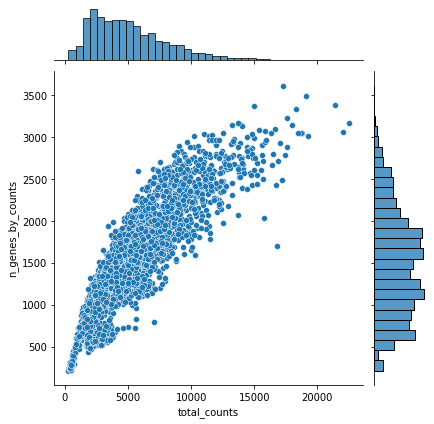

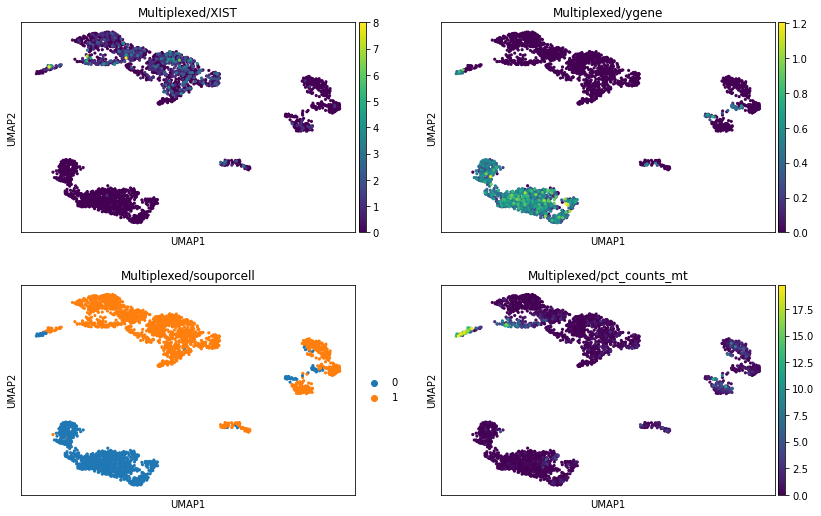

demultiplexed InfALL5 (female) have  1878  cells


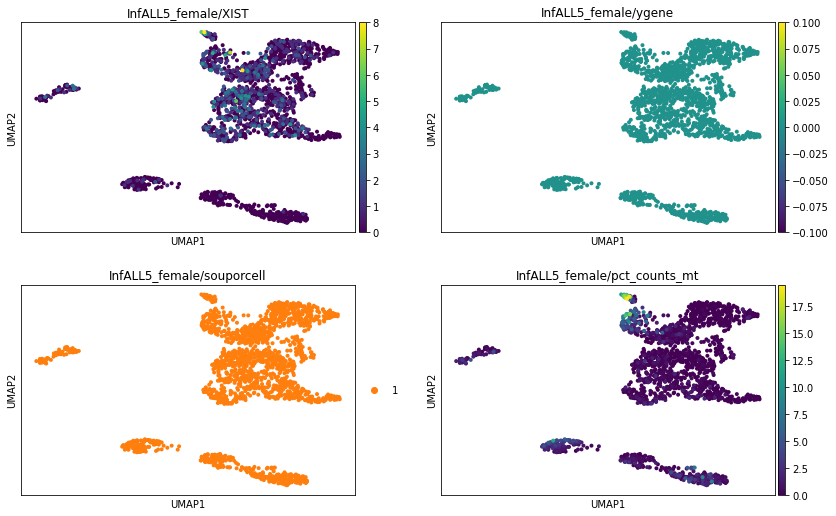

In [8]:
adata = sc.read_10x_mtx('data/single_cell_data/SoupX_processed_counts/ALL_AML_3/InfALL5_InfALL_CS_L826_LK387_strained/', cache=True)
adata.raw = adata
print('Multiplexed InfALL5 with InfALL_classSwitch after SoupX have ', adata.shape[0], ' cells')

sc.pp.filter_cells(adata, min_genes=200)
adata.var['mt'] = adata.var_names.str.startswith('MT-') 
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
# filter cells with mito content >20%
adata = adata[adata.obs.pct_counts_mt<20].copy()
sns.jointplot(data=adata.obs, x="total_counts", y="n_genes_by_counts")
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sorc = pd.read_csv('data/single_cell_data/InfALL5_InfALL_CS_L826_LK387_clusters.csv', sep = '\t',index_col=0)
sorc = sorc[sorc.status == 'singlet']
adata = adata[adata.obs_names.isin(sorc.index)].copy()

adata.obs['souporcell'] = sorc.assignment
adata.obs['ygene']= np.mean(adata[:, ['RPS4Y1', 'ZFY', 'DDX3Y', 'UTY', 'TMSB4Y', 'KDM5D', 'EIF1AY']].X, 1)

sc.pl.umap(adata, color = ['XIST', 'ygene', 'souporcell','pct_counts_mt'], ncols = 2, 
           title = ['Multiplexed/XIST', 'Multiplexed/ygene', 'Multiplexed/souporcell','Multiplexed/pct_counts_mt'])

adata_infALL5 = adata[adata.obs.souporcell == '1'].copy() #LK387 female infant KMT2A B-ALL
print('demultiplexed InfALL5 (female) have ', adata_infALL5.shape[0], ' cells')

sc.pp.neighbors(adata_infALL5)
sc.tl.umap(adata_infALL5)
sc.pl.umap(adata_infALL5, color = ['XIST', 'ygene', 'souporcell','pct_counts_mt'], ncols = 2,
          title = ['InfALL5_female/XIST', 'InfALL5_female/ygene', 'InfALL5_female/souporcell','InfALL5_female/pct_counts_mt'])

Now the same preprocessing for other samples

InfALL6 after SoupX have  8175  cells


         Falling back to preprocessing with `sc.pp.pca` and default params.


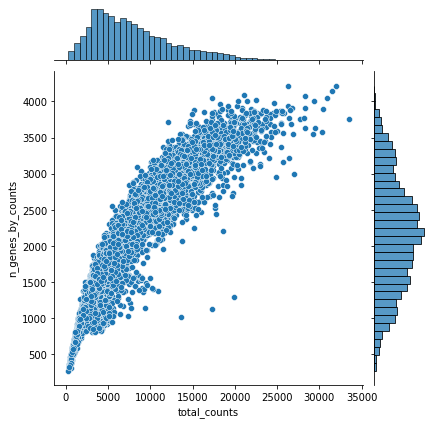

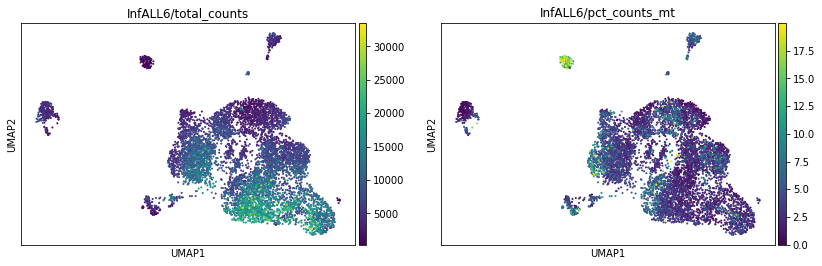

After filtering and preprocessing InfALL6 have  7141  cells


In [9]:
# Read SoupX processed data
adata_infALL6 = sc.read_10x_mtx('data/single_cell_data/SoupX_processed_counts/ALL_AML_3/InfALL6_L876_Dx_strained/', var_names='gene_symbols', cache=True)
adata_infALL6.raw = adata_infALL6
print('InfALL6 after SoupX have ', adata_infALL6.shape[0], ' cells')
sc.pp.filter_cells(adata_infALL6, min_genes=200)
adata_infALL6.var['mt'] = adata_infALL6.var_names.str.startswith('MT-') 
sc.pp.calculate_qc_metrics(adata_infALL6, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
# filter cells with mito content >20%
adata_infALL6 = adata_infALL6[adata_infALL6.obs.pct_counts_mt<20].copy()
sns.jointplot(data=adata_infALL6.obs, x="total_counts", y="n_genes_by_counts")
sc.pp.normalize_per_cell(adata_infALL6, counts_per_cell_after=1e4)
sc.pp.log1p(adata_infALL6)
sc.pp.neighbors(adata_infALL6)
sc.tl.umap(adata_infALL6)
sc.pl.umap(adata_infALL6, color = ['total_counts','pct_counts_mt'], title = ['InfALL6/total_counts','InfALL6/pct_counts_mt'])

print('After filtering and preprocessing InfALL6 have ', adata_infALL6.shape[0], ' cells')


InfALL7 after SoupX have  9199  cells


         Falling back to preprocessing with `sc.pp.pca` and default params.


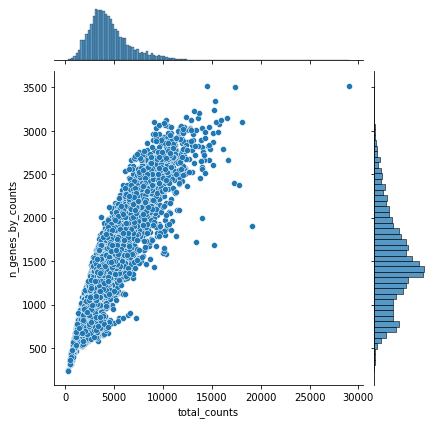

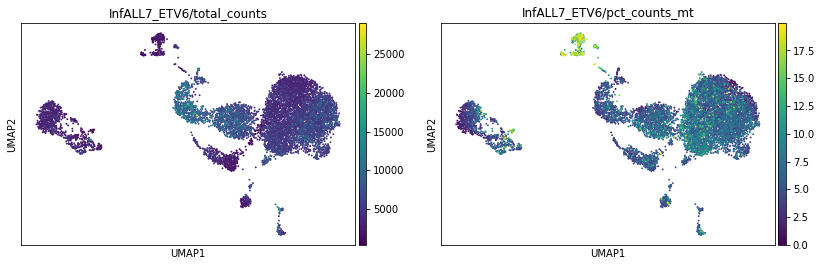

After filtering and preprocessing InfALL7 have  8474  cells


In [10]:
# Read SoupX processed data
adata_infALL7 = sc.read_10x_mtx('data/single_cell_data/SoupX_processed_counts/ALL_AML_3/InfALL7_ETV6_LK326_Dx_strained/', var_names='gene_symbols', cache=True)
adata_infALL7.raw = adata_infALL7
print('InfALL7 after SoupX have ', adata_infALL7.shape[0], ' cells')
sc.pp.filter_cells(adata_infALL7, min_genes=200)
adata_infALL7.var['mt'] = adata_infALL7.var_names.str.startswith('MT-') 
sc.pp.calculate_qc_metrics(adata_infALL7, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
# filter cells with mito content >20%
adata_infALL7 = adata_infALL7[adata_infALL7.obs.pct_counts_mt<20].copy()
sns.jointplot(data=adata_infALL7.obs, x="total_counts", y="n_genes_by_counts")
sc.pp.normalize_per_cell(adata_infALL7, counts_per_cell_after=1e4)
sc.pp.log1p(adata_infALL7)
sc.pp.neighbors(adata_infALL7)
sc.tl.umap(adata_infALL7)
sc.pl.umap(adata_infALL7, color = ['total_counts','pct_counts_mt'], title = ['InfALL7_ETV6/total_counts','InfALL7_ETV6/pct_counts_mt'])

print('After filtering and preprocessing InfALL7 have ', adata_infALL7.shape[0], ' cells')


InfALL8 after SoupX have  6805  cells


         Falling back to preprocessing with `sc.pp.pca` and default params.


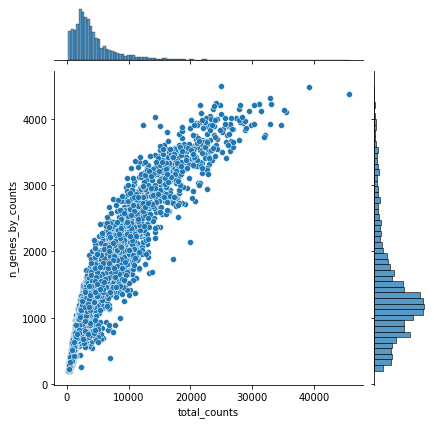

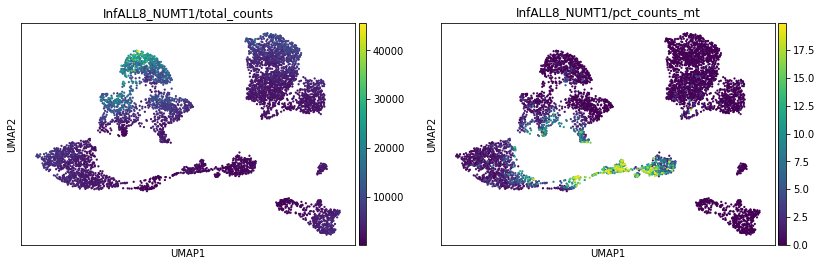

After filtering and preprocessing InfALL8 have  6017  cells


In [11]:
# Read SoupX processed data
adata_infALL8 = sc.read_10x_mtx('data/single_cell_data/SoupX_processed_counts/ALL_AML_3/InfALL8_NUMT1_Jacks_Dx_strained/', var_names='gene_symbols', cache=True)
adata_infALL8.raw = adata_infALL8
print('InfALL8 after SoupX have ', adata_infALL8.shape[0], ' cells')
sc.pp.filter_cells(adata_infALL8, min_genes=200)
adata_infALL8.var['mt'] = adata_infALL8.var_names.str.startswith('MT-') 
sc.pp.calculate_qc_metrics(adata_infALL8, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
# filter cells with mito content >20%
adata_infALL8 = adata_infALL8[adata_infALL8.obs.pct_counts_mt<20].copy()
sns.jointplot(data=adata_infALL8.obs, x="total_counts", y="n_genes_by_counts")
sc.pp.normalize_per_cell(adata_infALL8, counts_per_cell_after=1e4)
sc.pp.log1p(adata_infALL8)
sc.pp.neighbors(adata_infALL8)
sc.tl.umap(adata_infALL8)
sc.pl.umap(adata_infALL8, color = ['total_counts','pct_counts_mt'], title = ['InfALL8_NUMT1/total_counts','InfALL8_NUMT1/pct_counts_mt'])

print('After filtering and preprocessing InfALL8 have ', adata_infALL8.shape[0], ' cells')


<a id='cluster'></a>



# Merging data, UMAPs etc

For each of single cell samples Laura Jardine have annotated cluster of cells as either cancerous or non-cancerous cells according to the expression of immunophenotype genes as mentioned in the the paper and table S1. I have created columns "patient_cancer" for each of the samples which stored patient ID with either Cancer or Normal phenotype assignment.

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np


all_aml_files = ['data/single_cell_data/final_h5ad/InfALL1M_Dx_combined_cancerInfo.h5ad',
                 'data/single_cell_data/final_h5ad/InfALL2F_Dx_combined_cancerInfo.h5ad',
                 'data/single_cell_data/final_h5ad/InfAML1_Dx_cancerInfo.h5ad',
                 'data/single_cell_data/final_h5ad/InfALL3_Dx_cancerInfo.h5ad',
                 'data/single_cell_data/final_h5ad/InfALL4_Dx_cancerInfo.h5ad',
                 'data/single_cell_data/final_h5ad/InfAML2_Dx_cancerInfo.h5ad',
                'data/single_cell_data/final_h5ad/InfALL5_akaLK387_Dx_cancerInfo.h5ad',
                'data/single_cell_data/final_h5ad/InfALL6_akaL876_Dx_cancerInfo.h5ad',
                'data/single_cell_data/final_h5ad/InfALL7_ETV6_Dx_cancerInfo.h5ad',
                'data/single_cell_data/final_h5ad/InfALL8_NUMT1_Dx_cancerInfo.h5ad']
adata_Leuk_diag = {}
sample_names = ['InfALL1', 'InfALL2','InfAML1',
                'InfALL3', 'InfALL4','InfAML2',
                'InfALL5','InfALL6','InfALL7_ETV6','InfALL8_NUMT1']

adata_ALL_all = []
for i, filen in enumerate(all_aml_files[0:]):
    print(filen)
    adata_ALL_all.append(sc.read_h5ad(filen))

adata_ALL_new = adata_ALL_all[0].concatenate(adata_ALL_all[1:], batch_categories=sample_names)
adata_ALL_new.obs_names = pd.Series(adata_ALL_new.obs_names).str.rsplit('-', n=1, expand = True)[0].values
adata_ALL_new.obs.head()



Bad key "text.kerning_factor" on line 4 in
/Users/ek12/anaconda2/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


data/single_cell_data/final_h5ad/InfALL1M_Dx_combined_cancerInfo.h5ad
data/single_cell_data/final_h5ad/InfALL2F_Dx_combined_cancerInfo.h5ad
data/single_cell_data/final_h5ad/InfAML1_Dx_cancerInfo.h5ad
data/single_cell_data/final_h5ad/InfALL3_Dx_cancerInfo.h5ad
data/single_cell_data/final_h5ad/InfALL4_Dx_cancerInfo.h5ad
data/single_cell_data/final_h5ad/InfAML2_Dx_cancerInfo.h5ad
data/single_cell_data/final_h5ad/InfALL5_akaLK387_Dx_cancerInfo.h5ad
data/single_cell_data/final_h5ad/InfALL6_akaL876_Dx_cancerInfo.h5ad
data/single_cell_data/final_h5ad/InfALL7_ETV6_Dx_cancerInfo.h5ad
data/single_cell_data/final_h5ad/InfALL8_NUMT1_Dx_cancerInfo.h5ad


,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,n_counts,souporcell,ygene,batch,patient_cancer_withNA,patient_cancer,louvain,newcn
AAACGGGAGAAGGGTA-1/InfALL1,1286,1286,3829.0,91.0,2.376600,3829.0,1,0.348242,InfALL1,NaN,InfALL1/Cancer,3,NaN
AAACGGGCAGCTCGCA-1/InfALL1,729,729,2805.0,43.0,1.532977,2805.0,1,0.000000,InfALL1,InfALL1/Normal,InfALL1/Normal,6,NaN
AAAGCAAGTAAGTAGT-1/InfALL1,633,633,1643.0,29.0,1.765064,1643.0,1,0.559480,InfALL1,InfALL1/Cancer,InfALL1/Cancer,0,NaN
AAAGCAATCAAGAAGT-1/InfALL1,993,993,2499.0,29.0,1.160464,2499.0,1,0.313940,InfALL1,InfALL1/Cancer,InfALL1/Cancer,4,NaN
AAAGTAGAGAGTACAT-1/InfALL1,934,934,2484.0,12.0,0.483092,2484.0,1,0.314705,InfALL1,InfALL1/Cancer,InfALL1/Cancer,0,NaN


... storing 'souporcell' as categorical
... storing 'patient_cancer_withNA' as categorical
... storing 'louvain' as categorical
... storing 'newcn' as categorical


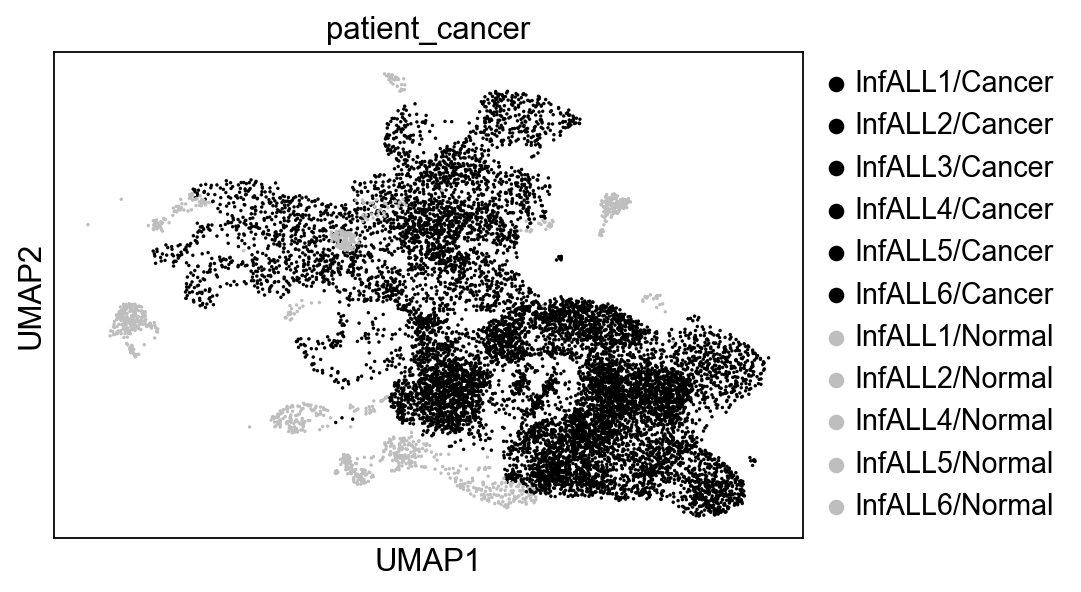

In [2]:
# some preprocessing to make sure that the text in figures are rendered properly
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# filter out to only include KMT2A-rearranged B-ALL (InfALL1-6)
adata_ALL_ALL = adata_ALL_new[adata_ALL_new.obs.patient_cancer.str.contains('InfALL')].copy()
adata_ALL_ALL = adata_ALL_ALL[~(adata_ALL_ALL.obs.patient_cancer.str.contains('ETV6')|
                             adata_ALL_ALL.obs.patient_cancer.str.contains('NUMT1'))].copy()

'''sc.pp.normalize_per_cell(adata_ALL_ALL, counts_per_cell_after=1e4)
sc.pp.log1p(adata_ALL_ALL)
sc.pp.neighbors(adata_ALL_ALL)
sc.tl.umap(adata_ALL_ALL)'''

# Reorder category so that we have all "cancer" cells first and then "Normal"
adata_ALL_ALL.obs.patient_cancer = adata_ALL_ALL.obs.patient_cancer.astype('category')
obs_order = list(np.unique(adata_ALL_ALL.obs['patient_cancer'][adata_ALL_ALL.obs['patient_cancer'].str.contains('Cancer')].values))
obs_order.extend(list(np.unique(adata_ALL_ALL.obs['patient_cancer'][adata_ALL_ALL.obs['patient_cancer'].str.contains('Normal')].values)))

adata_ALL_ALL.obs['patient_cancer'].cat.reorder_categories(obs_order, inplace=True)
adata_ALL_ALL.obs['patient_cancer'] = adata_ALL_ALL.obs['patient_cancer'].sort_values()

sc.set_figure_params(figsize=[6,4])

adata_ALL_ALL.uns['patient_cancer_colors'] = ['#000000']*adata_ALL_ALL.obs['patient_cancer'].nunique()
adata_ALL_ALL.uns['patient_cancer_colors'][6:] = ['#BEBEBE']*5
sc.pl.umap(adata_ALL_ALL, color = 'patient_cancer')


... storing 'louvain' as categorical
... storing 'newcn' as categorical
... storing 'patient_cancer_withNA' as categorical
... storing 'souporcell' as categorical


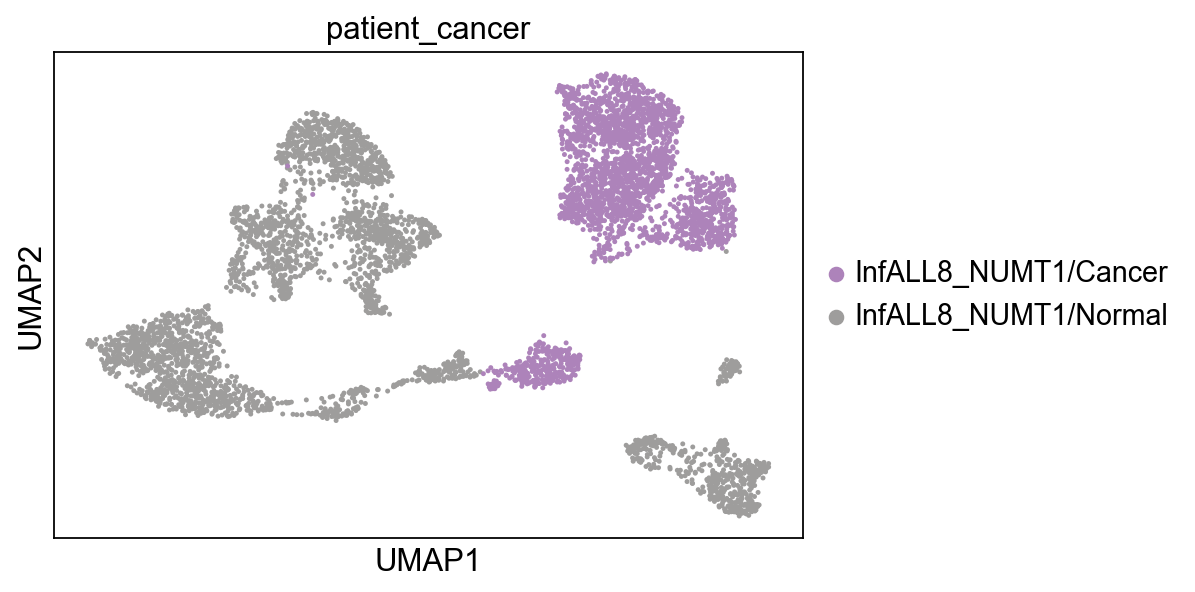

In [10]:
# Same for NUMT1
adata_ALL_ALL = adata_ALL_new[adata_ALL_new.obs.patient_cancer.str.contains('NUMT1')].copy()

adata_ALL_ALL.obs.patient_cancer = adata_ALL_ALL.obs.patient_cancer.astype('category')
base = r'^{}'
expr = '(?=.*{})'
obs_order = list(np.unique(adata_ALL_ALL.obs['patient_cancer'][adata_ALL_ALL.obs['patient_cancer'].str.contains(base.format(''.join(expr.format(w) for w in ['Cancer'])))].values))
obs_order.extend(list(np.unique(adata_ALL_ALL.obs['patient_cancer'][adata_ALL_ALL.obs['patient_cancer'].str.contains(base.format(''.join(expr.format(w) for w in ['Normal'])))].values)))

adata_ALL_ALL.obs['patient_cancer'].cat.reorder_categories(obs_order, inplace=True)
adata_ALL_ALL.obs['patient_cancer'] = adata_ALL_ALL.obs['patient_cancer'].sort_values()


sc.set_figure_params(figsize=[6,4], dpi_save=300)

adata_ALL_ALL.uns['patient_cancer_colors'] = ['#000000']*adata_ALL_ALL.obs['patient_cancer'].nunique()
adata_ALL_ALL.uns['patient_cancer_colors'][1] = '#BEBEBE'
sc.pl.umap(adata_ALL_ALL, color = 'patient_cancer')


... storing 'louvain' as categorical
... storing 'newcn' as categorical
... storing 'patient_cancer_withNA' as categorical
... storing 'souporcell' as categorical


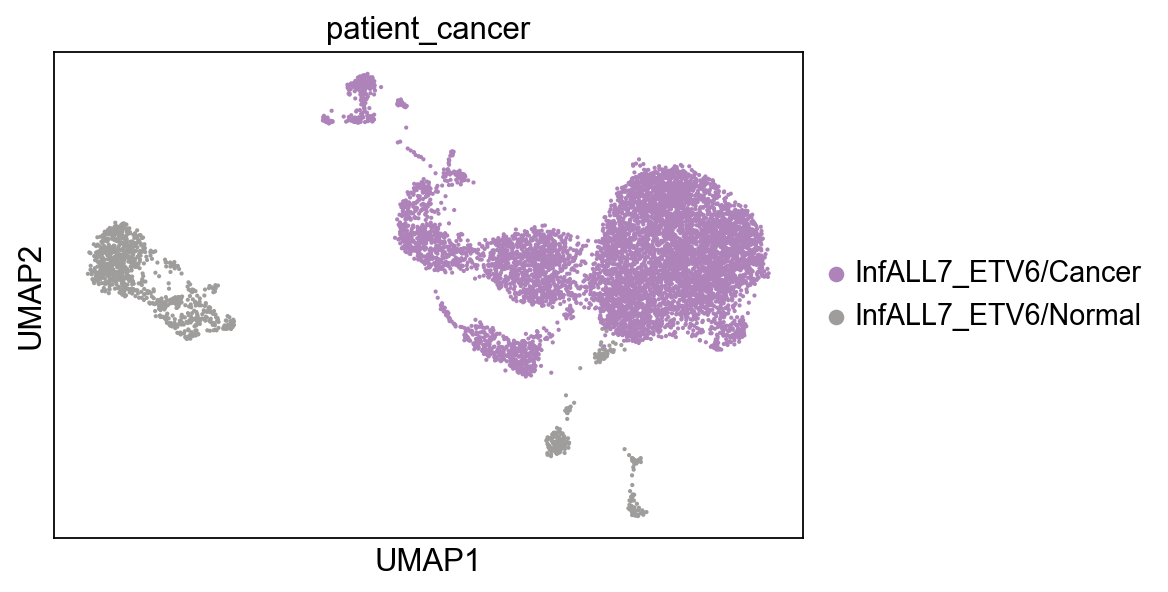

In [11]:
# Same for ETV6-RUNX1
adata_ALL_ALL = adata_ALL_new[adata_ALL_new.obs.patient_cancer.str.contains('ETV6')].copy()

adata_ALL_ALL.obs.patient_cancer = adata_ALL_ALL.obs.patient_cancer.astype('category')
base = r'^{}'
expr = '(?=.*{})'
obs_order = list(np.unique(adata_ALL_ALL.obs['patient_cancer'][adata_ALL_ALL.obs['patient_cancer'].str.contains(base.format(''.join(expr.format(w) for w in ['Cancer'])))].values))
obs_order.extend(list(np.unique(adata_ALL_ALL.obs['patient_cancer'][adata_ALL_ALL.obs['patient_cancer'].str.contains(base.format(''.join(expr.format(w) for w in ['Normal'])))].values)))

adata_ALL_ALL.obs['patient_cancer'].cat.reorder_categories(obs_order, inplace=True)
adata_ALL_ALL.obs['patient_cancer'] = adata_ALL_ALL.obs['patient_cancer'].sort_values()

sc.set_figure_params(figsize=[6,4], dpi_save=300)
adata_ALL_ALL.uns['patient_cancer_colors'] = ['#000000']*adata_ALL_ALL.obs['patient_cancer'].nunique()
adata_ALL_ALL.uns['patient_cancer_colors'][1] = '#BEBEBE'
sc.pl.umap(adata_ALL_ALL, color = 'patient_cancer')


... storing 'louvain' as categorical
... storing 'newcn' as categorical
... storing 'patient_cancer_withNA' as categorical
... storing 'souporcell' as categorical


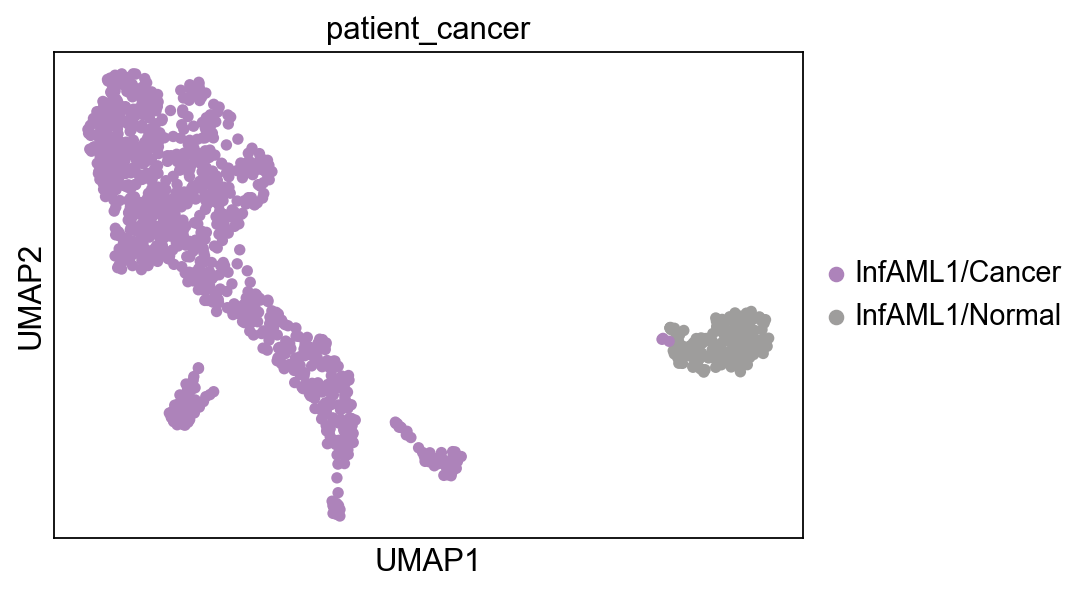

In [12]:
# Now Infant AML1
adata_ALL_ALL = adata_ALL_new[adata_ALL_new.obs.patient_cancer.str.contains('AML1')].copy()


adata_ALL_ALL.obs.patient_cancer = adata_ALL_ALL.obs.patient_cancer.astype('category')
base = r'^{}'
expr = '(?=.*{})'
obs_order = list(np.unique(adata_ALL_ALL.obs['patient_cancer'][adata_ALL_ALL.obs['patient_cancer'].str.contains(base.format(''.join(expr.format(w) for w in ['Cancer'])))].values))
obs_order.extend(list(np.unique(adata_ALL_ALL.obs['patient_cancer'][adata_ALL_ALL.obs['patient_cancer'].str.contains(base.format(''.join(expr.format(w) for w in ['Normal'])))].values)))

adata_ALL_ALL.obs['patient_cancer'].cat.reorder_categories(obs_order, inplace=True)
adata_ALL_ALL.obs['patient_cancer'] = adata_ALL_ALL.obs['patient_cancer'].sort_values()


sc.set_figure_params(figsize=[6,4], dpi_save=300)
adata_ALL_ALL.uns['patient_cancer_colors'] = ['#000000']*adata_ALL_ALL.obs['patient_cancer'].nunique()
adata_ALL_ALL.uns['patient_cancer_colors'][1] = '#BEBEBE'
sc.pl.umap(adata_ALL_ALL, color = 'patient_cancer')


... storing 'louvain' as categorical
... storing 'newcn' as categorical
... storing 'patient_cancer_withNA' as categorical
... storing 'souporcell' as categorical


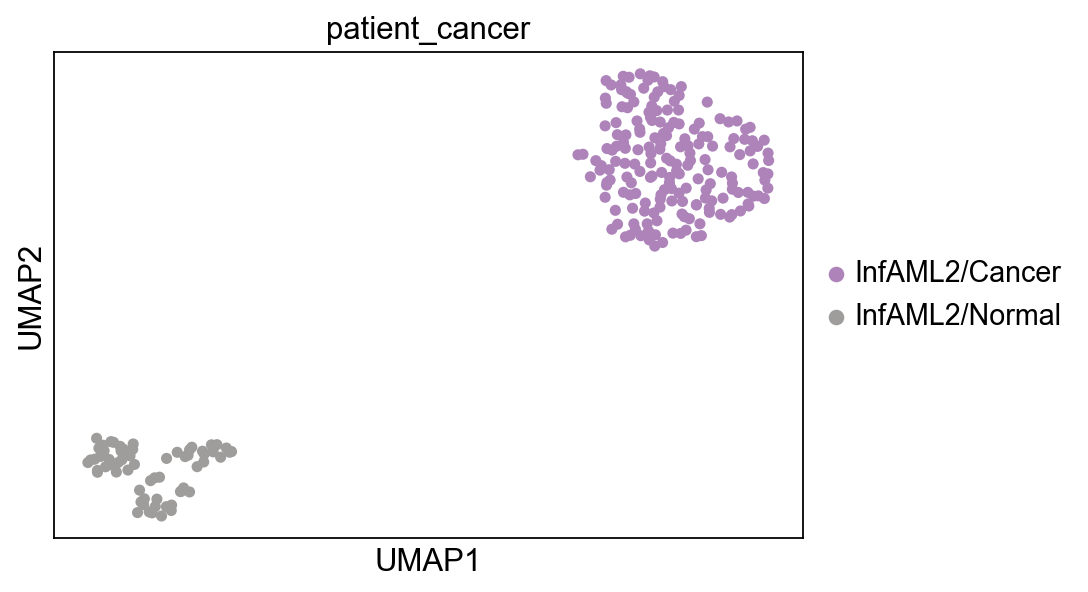

In [13]:
# And last sample - megakaryoblastic AML (AML2)

adata_ALL_ALL = adata_ALL_new[adata_ALL_new.obs.patient_cancer.str.contains('AML2')].copy()

adata_ALL_ALL.obs.patient_cancer = adata_ALL_ALL.obs.patient_cancer.astype('category')
base = r'^{}'
expr = '(?=.*{})'
obs_order = list(np.unique(adata_ALL_ALL.obs['patient_cancer'][adata_ALL_ALL.obs['patient_cancer'].str.contains(base.format(''.join(expr.format(w) for w in ['Cancer'])))].values))
obs_order.extend(list(np.unique(adata_ALL_ALL.obs['patient_cancer'][adata_ALL_ALL.obs['patient_cancer'].str.contains(base.format(''.join(expr.format(w) for w in ['Normal'])))].values)))

adata_ALL_ALL.obs['patient_cancer'].cat.reorder_categories(obs_order, inplace=True)
adata_ALL_ALL.obs['patient_cancer'] = adata_ALL_ALL.obs['patient_cancer'].sort_values()

sc.set_figure_params(figsize=[6,4], dpi_save=300)

adata_ALL_ALL.uns['patient_cancer_colors'] = ['#000000']*adata_ALL_ALL.obs['patient_cancer'].nunique()
adata_ALL_ALL.uns['patient_cancer_colors'][1] = '#BEBEBE'
sc.pl.umap(adata_ALL_ALL, color = 'patient_cancer', size = 100)


<a id='logreg'></a>


# Logistic regression

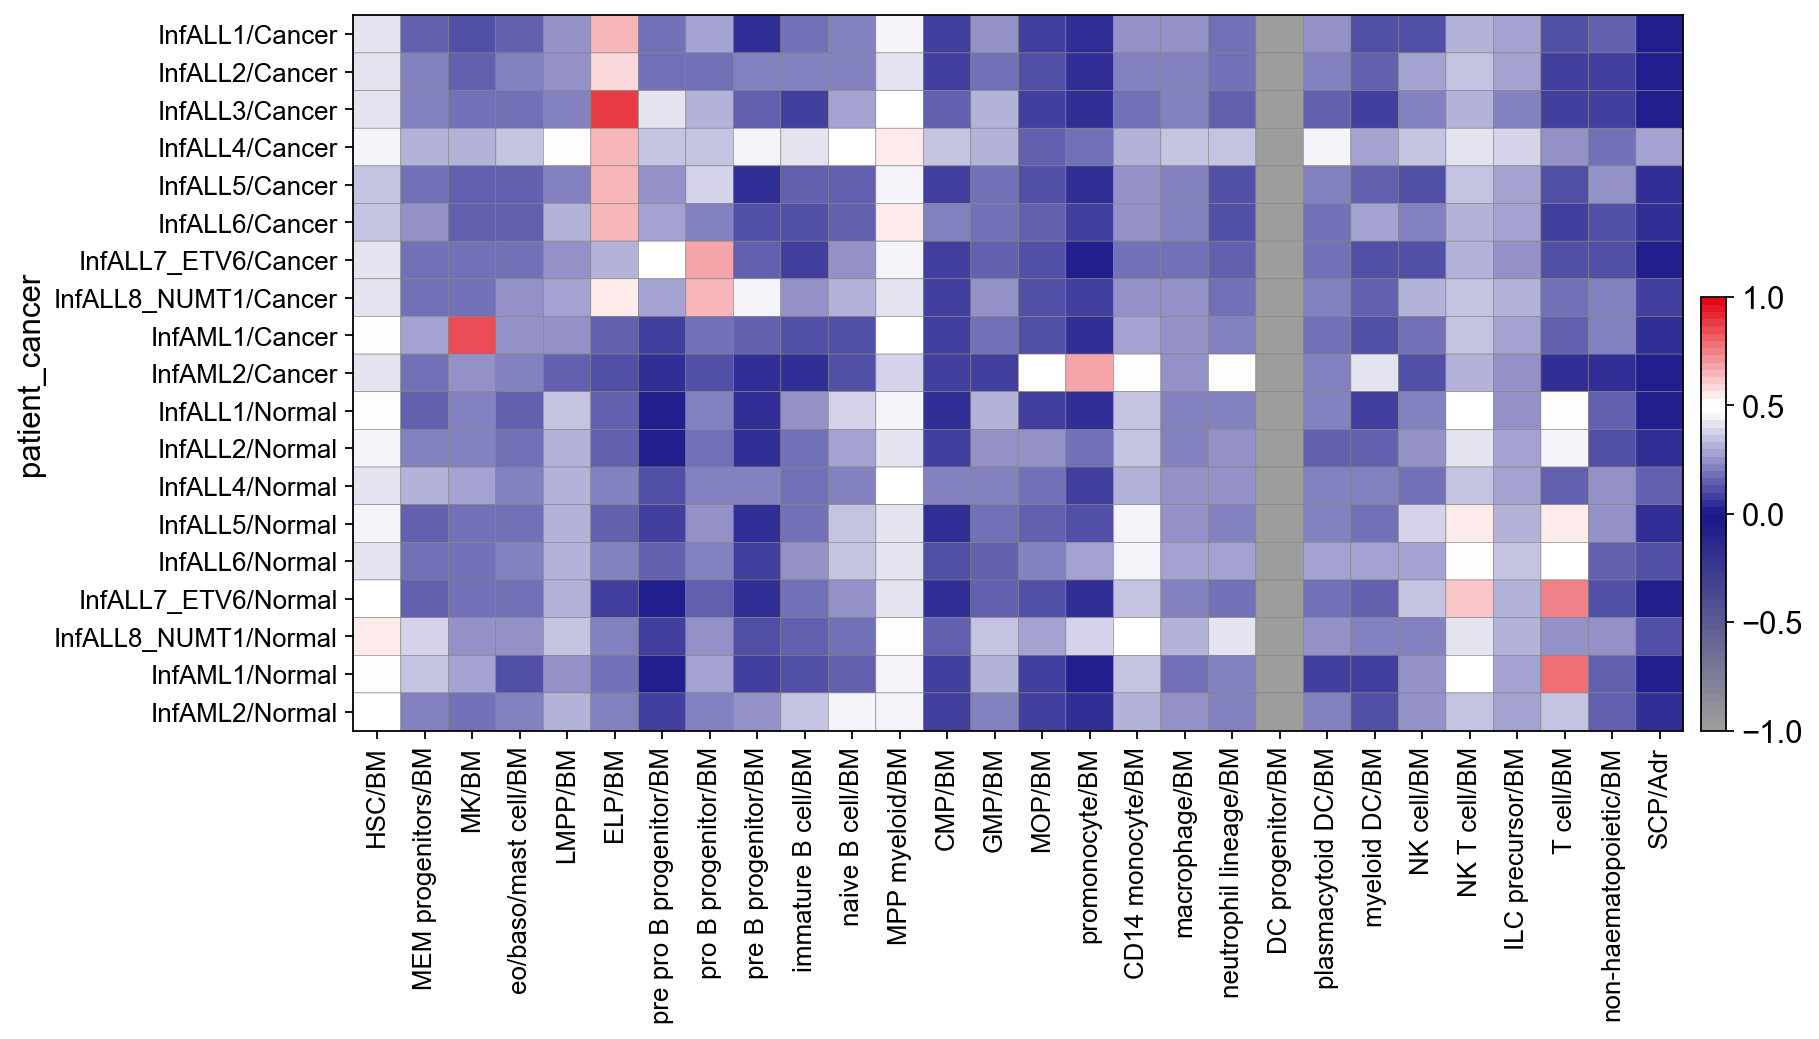

GridSpec(2, 3, height_ratios=[0, 10.5], width_ratios=[10.8, 0, 0.2])

In [15]:
import pandas as pd
import scanpy as sc
from matplotlib.colors import LinearSegmentedColormap

tmpf = pd.read_csv('data/logreg/InfALL_allSAMPLES_LogregFBM_wLMPP.csv', header=0, index_col=0)
adata_new = sc.AnnData(tmpf)
adata_new.X[np.isnan(adata_new.X)] = -1

adata_new.obs['patient_cancer'] = adata_ALL_new.obs.loc[tmpf.index].patient_cancer

adata_new.var_names = adata_new.var_names+'/BM'
vn = pd.Series(adata_new.var_names)
vn[vn == 'SCP/BM'] = 'SCP/Adr'
adata_new.var_names = vn.values

base = r'^{}'
expr = '(?=.*{})'
obs_order = list(np.unique(adata_new.obs['patient_cancer'][adata_new.obs['patient_cancer'].str.contains(base.format(''.join(expr.format(w) for w in ['Cancer', 'ALL'])))].values))
obs_order.extend(list(np.unique(adata_new.obs['patient_cancer'][adata_new.obs['patient_cancer'].str.contains(base.format(''.join(expr.format(w) for w in ['Cancer', 'AML'])))].values)))
obs_order.extend(list(np.unique(adata_new.obs['patient_cancer'][adata_new.obs['patient_cancer'].str.contains(base.format(''.join(expr.format(w) for w in ['Normal', 'ALL'])))].values)))
obs_order.extend(list(np.unique(adata_new.obs['patient_cancer'][adata_new.obs['patient_cancer'].str.contains(base.format(''.join(expr.format(w) for w in ['Normal', 'AML'])))].values)))

adata_new.obs['patient_cancer'] = adata_new.obs['patient_cancer'].astype('category')
adata_new.obs['patient_cancer'].cat.reorder_categories(obs_order, inplace=True)
adata_new.obs['patient_cancer'] = adata_new.obs['patient_cancer'].sort_values()
adata_new = adata_new[~adata_new.obs.patient_cancer.str.contains('low')]
adata_new = adata_new[~adata_new.obs.patient_cancer.str.contains('myel')]

cm = LinearSegmentedColormap.from_list('mycmap', [(0, '#9D9D9C'), (0.5, '#191689'),(0.74, '#FFFFFF'), (0.76, '#FFFFFF'), (1, '#E30613')], N=60)
tmp = pd.read_csv('data/logreg/FetalBM_broadanno.csv', usecols=[1,2], index_col=0)
tmp = tmp['suggested labels for BM reference'].drop_duplicates().values
tmp = list(tmp+'/BM') 
tmp.append('SCP/Adr')
tmp = [x for x in tmp if x in adata_new.var_names]

sc.pl.matrixplot(adata_new, tmp, groupby='patient_cancer', figsize=[11,6], vmax =1,cmap = cm)

